In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.integrate
import scipy

In [3]:
nvox = 100 # Number of voxels
ntrials = 50 # Number of trials
nchan = 8 # Number of channels

In [12]:
# functions
def fun_basis(s): #standard encoding model with 8 channels
    TuningCentres = np.arange(0,2*np.pi-0.001,2*np.pi/8)
    s = np.ravel(s)
    c = np.maximum(0,np.cos(np.tile(s,[8,1]).T-TuningCentres))**5
    return c

def MatProdDiag(mat1,mat2):
    M = np.multiply(mat1,mat2.T)
    out = np.sum(M, axis=1)
    return out

def fun_minLL(inits): # "new" encoding model with channelspecific and voxspecific noise
    weighted_basis = W@fun_basis(inits).T 
    bwc = np.array([betas-weighted_basis[:,i] for i in range(weighted_basis.shape[1])]).T
    negll = 0.5*MatProdDiag(bwc.T@prec_mat,bwc) #prec_mat is adding channel + voxel specific noises
    return negll
    
def globminsearch():
    inits = np.linspace(0, 2*np.pi, 200)
    fvals = fun_minLL(inits)
    minI = np.argmin(fvals)
    sol, mll, iter, funcalls, warnflag = scipy.optimize.fmin(fun_minLL,
                    x0=inits[minI],maxiter=1e10, xtol=1e-10,full_output=True,disp=False)
    return sol, mll

def fun_lik(s):
    ll = np.exp(-fun_minLL(s)+mll)
    return ll

def fun_Eth1(s):
    out = (fun_lik(s)/Integ).T*np.exp(1j*s)
    return out

def complex_quadrature(func, a, b, **kwargs):
    def real_func(x):
        return scipy.real(func(x))
    def imag_func(x):
        return scipy.imag(func(x))
    real_integral = scipy.integrate.quad(real_func, a, b, **kwargs)
    imag_integral = scipy.integrate.quad(imag_func, a, b, **kwargs)
    return (real_integral[0] + 1j*imag_integral[0], real_integral[1:], imag_integral[1:])  

def mat_div(a,b): # a/b matlab style
    return np.linalg.lstsq(b.T, a.T, 0)[0].T

def invSNC(W, tau, sig, rho): # function to create prec_mat
    # PS: I think there's a problem here since this prec_mat != np.linalg.inv(cov_sim)?
    nvox = len(tau)
    alpha = 1/(1-rho)
    Fi = np.round(alpha*np.diag(tau**-2),4);          
    ti = 1/tau
    Di = Fi - (rho*alpha**2*(ti*ti.T)) / (1+rho*nvox*alpha)
    DiW = Di@W
    WtDiW = W.T@DiW
    prec_mat = Di - mat_div(DiW,(1/sig**2*np.eye(8)+WtDiW))@DiW.T
    ld = 2*np.sum(np.log(np.diag(np.linalg.cholesky(np.eye(nchan)+sig**2*WtDiW)))) + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))
    return [prec_mat, ld]

# below function in progress:
def fun_minLL_norm(tau,sig,rho): 
    #ntrials, nvox, and noise need already be defined
    [omi, NormConst] = invSNC(W, tau, sig, rho)
    XXt = noise.T@noise
    negloglik = (1/ntrials)*(XXt.T@omi.T) + NormConst
    if not np.isreal(negloglik):
        negloglik = np.inf
    # calculate derivate not translated over  

In [4]:
# original JC functions
# functions
def fun_basis(s):
    TuningCentres = np.arange(0,2*np.pi-0.001,2*np.pi/8)
    s = np.ravel(s)
    c = np.maximum(0,np.cos(np.tile(s,[8,1]).T-TuningCentres))**5
    return c

def MatProdDiag(mat1,mat2):
    M = np.multiply(mat1,mat2.T)
    out = np.sum(M, axis=1)
    return out

def fun_minLL(s):
    bwc = b-W@fun_basis(s).T 
    negll = 0.5*MatProdDiag(bwc.T@prec_mat,bwc)
    return negll

def globminsearch():
    inits = np.linspace(0, 2*np.pi, 200)
    fvals = fun_minLL(inits)
    minI = np.argmin(fvals)
    sol, mll, iter, funcalls, warnflag = scipy.optimize.fmin(fun_minLL, x0=inits[minI],maxiter=1e10, xtol=1e-10,full_output=True,disp=False)
    return sol, mll

def fun_lik(s):
    ll = np.exp(-fun_minLL(s)+mll)
    return ll

def fun_Eth1(s):
    out = (fun_lik(s)/Integ).T*np.exp(1j*s)
    return out

def complex_quadrature(func, a, b, **kwargs):
    def real_func(x):
        return scipy.real(func(x))
    def imag_func(x):
        return scipy.imag(func(x))
    real_integral = scipy.integrate.quad(real_func, a, b, **kwargs)
    imag_integral = scipy.integrate.quad(imag_func, a, b, **kwargs)
    return (real_integral[0] + 1j*imag_integral[0], real_integral[1:], imag_integral[1:])

In [13]:
# Simulate generative model parameters & resulting covariance matrix
W = np.random.randn(nvox, nchan)
tau_sim = np.random.randn(nvox,1)*0.035+0.7 # voxel-specific noise
sig_sim = 0.3 # channel-specific noise
rho_sim = 0.05 # noise shared globally among voxels

# eta is channel-specific noise, modeled
# as a normal distribution centered at 0 with standard deviation sigma

Define $W$,$\tau$,$\sigma$,$\rho$

In [14]:
cov_sim = ((1-rho_sim)*np.diag(np.ravel(tau_sim)**2) 
           + rho_sim*(tau_sim@tau_sim.T) 
           + sig_sim**2*(W@W.T))

Define $\Omega$
$$\Omega=(1-\rho)I\circ\tau\tau^T + \rho\tau\tau^T + \sigma^2WW^T$$

In [15]:
prec_mat = np.linalg.inv(cov_sim)
# prec_mat, _ = invSNC(W, tau_sim, sig_sim, rho_sim)

In [16]:
Q = np.linalg.cholesky(cov_sim)
noise = (Q@np.random.randn(ntrials,nvox).T).T

s_sim = np.random.rand(ntrials,1)*2*np.pi
c_sim = fun_basis(s_sim)
samples = (W@c_sim.T).T + noise

In [39]:
# Building the encoder

# estimate tau rho and sig by minimizing a multivariate function, 
# result should be similar to simulated values if correct

# not translated over yet, see fun_minLL_norm


In [37]:
# Decoding

est = np.zeros(ntrials)
unc = np.zeros(ntrials)
for iTrial in np.arange(ntrials):
    betas = samples[iTrial, :].T # what was the activation for each voxel for given trial?
    
    # Find the maximum likelihood so we can normalize the likelihood to a numerically feasible range 
        # PS: this step takes the voxel signals and subtracts it from the weighted basis set to calculate
        # a loss function. All these values, b, W, and basis set are constant, what is being searched for is 
        # simply where on the xaxis the maximal activation is for every voxel, and then averaging across voxels.
        # see visualization of these steps in cell below
    _, mll = globminsearch()
    
    # Compute the integral of the likelihood so we can normalize to a probability distribution over s
    Integ = scipy.integrate.quad(fun_lik, 0, 2*np.pi, epsabs=1e-12)[0]
    
    # Compute the first circular moment (aka expected value) of the normalized likelihood
    E1 = complex_quadrature(fun_Eth1,0, 2*np.pi, epsabs= 1e-12)[0]
    
    # Compute the circular mean of the normalized likelihood
    est[iTrial] = np.mod(np.angle(E1), 2*np.pi)/np.pi*90
    
    # Compute the circular SD of the normalized likelihood          
    unc[iTrial] = np.sqrt(-2*np.log(abs(E1)))/np.pi*90

## Visualization of decoding minimization steps:

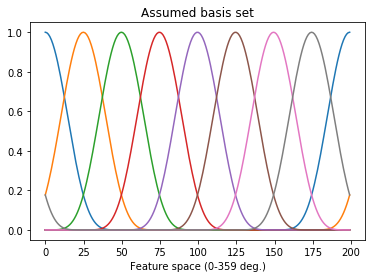

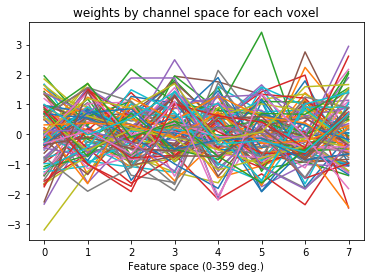

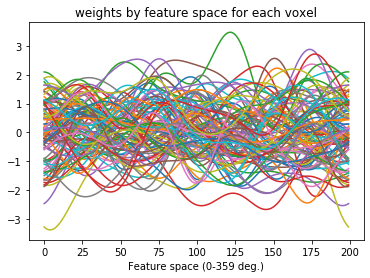

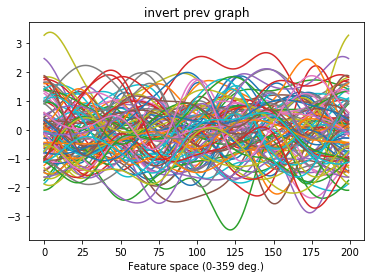

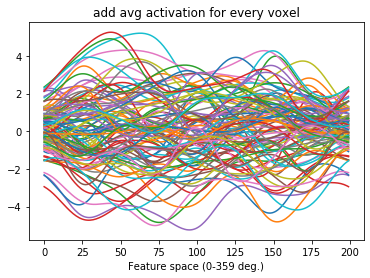

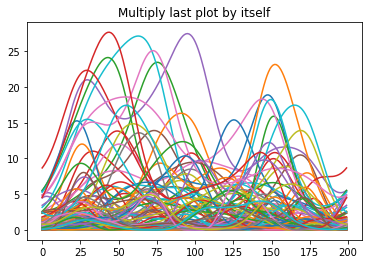

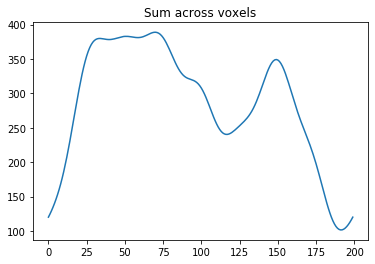

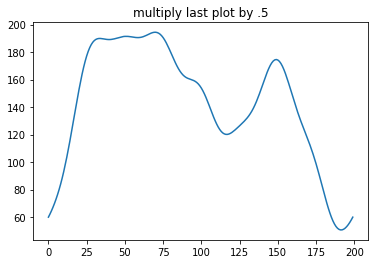

the point on x-axis with lowest height is the optimal feature

now we can redo this and incorporate channel specific and voxel specific noise by incorporating prec_mat


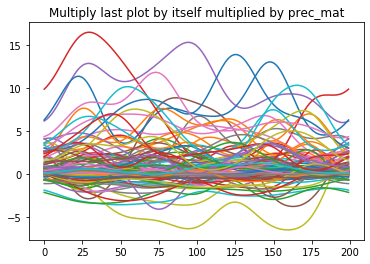

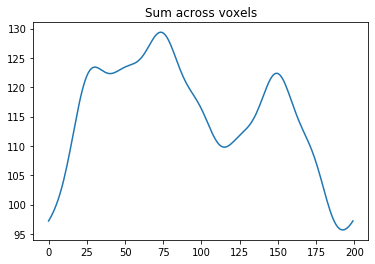

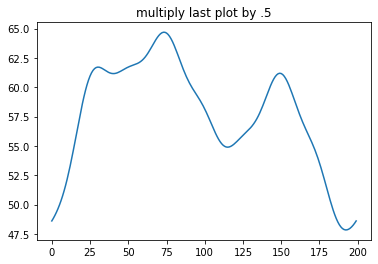

In [28]:
xspots=np.linspace(0, 2*np.pi, 200)

plt.plot(fun_basis(xspots))
plt.title("Assumed basis set")
plt.xlabel("Feature space (0-359 deg.)")
plt.show()

plt.plot(W.T)
plt.title("weights by channel space for each voxel")
plt.xlabel("Feature space (0-359 deg.)")
plt.show()

plt.plot((W@fun_basis(xspots).T).T)
plt.title("weights by feature space for each voxel")
plt.xlabel("Feature space (0-359 deg.)")
plt.show()

plt.plot((-W@fun_basis(xspots).T).T)
plt.title("invert prev graph")
plt.xlabel("Feature space (0-359 deg.)")
plt.show()

weighted_basis=W@fun_basis(xspots).T
bwc=np.array([betas-weighted_basis[:,i] for i in range(weighted_basis.shape[1])]).T
plt.plot(bwc.T)
plt.title("add avg activation for every voxel")
plt.xlabel("Feature space (0-359 deg.)")
plt.show()

plt.plot(np.multiply(bwc.T,bwc.T))
plt.title("Multiply last plot by itself")
plt.show()

plt.plot(np.sum(np.multiply(bwc.T,bwc.T),1))
plt.title("Sum across voxels")
plt.show()

plt.title("multiply last plot by .5")
plt.plot(0.5*MatProdDiag(bwc.T,bwc))
plt.show()

print('the point on x-axis with lowest height is the optimal feature')

print('\nnow we can redo this and incorporate channel specific and voxel specific noise by incorporating prec_mat')

plt.plot(np.multiply(bwc.T@prec_mat,bwc.T))
plt.title("Multiply last plot by itself multiplied by prec_mat")
plt.show()

plt.plot(np.sum(np.multiply(bwc.T@prec_mat,bwc.T),1))
plt.title("Sum across voxels")
plt.show()

plt.plot(0.5*MatProdDiag(bwc.T@prec_mat,bwc))
plt.title("multiply last plot by .5")
plt.show()


Text(0, 0.5, 'estimated')

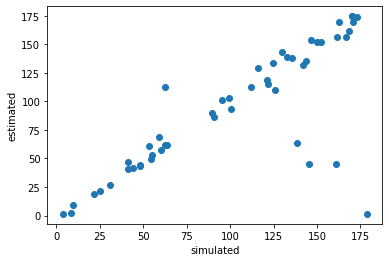

In [20]:
plt.scatter(s_sim/2/np.pi*180,est)
plt.xlabel('simulated')
plt.ylabel('estimated')

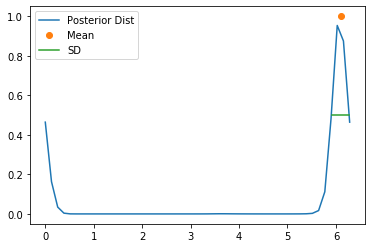

In [21]:
x = np.linspace(0,2*np.pi)
plt.plot(x,fun_lik(x))
plt.plot(np.deg2rad(est[iTrial])*2,1,'o')
plt.plot([np.deg2rad(est[iTrial])*2-np.deg2rad(unc[iTrial])*2,
          np.deg2rad(est[iTrial])*2+np.deg2rad(unc[iTrial])*2,],[.5,.5],'-')
plt.legend(['Posterior Dist','Mean','SD'])

# Translation into readable english

Assume that we have vox_data, a matrix of voxel activations (ntrials by nvox)

Let's first assume a basis set of nchan channels (i.e., fun_basis(inits) is a 200 by nchan matrix; here its 200 but it should probably be changed to 360 or 180 to make it easily comparable with desired feature space)






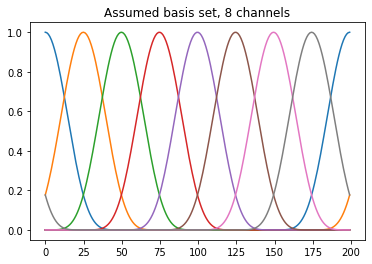

In [23]:
inits = np.linspace(0, 2*np.pi, 200)
plt.plot(fun_basis(inits))
plt.title("Assumed basis set, 8 channels")
plt.show()

Calculate W (trial weights, a nvox by nchan matrix) by multiplying the basis set by the trial features: basis_set[trial_features,:]



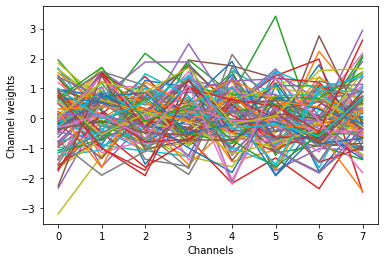

Each colored line is a different voxel


In [29]:
plt.plot(W.T)
plt.ylabel("Channel weights")
plt.xlabel("Channels")
plt.show()
print("Each colored line is a different voxel")

Now let's imagine that W is influenced by global (rho), channel-specific (sig), and voxel-specific (tau) noise/variance

We can estimate a covariance matrix (cov_sim, nvox by nvox dimensions) that characterizes the relationship between voxels given a specified W, rho, sig, and tau values. 

W is important to the covariance matrix because voxels receptive to channel 3 should have increased covariance with voxels receptive to channel 4 than channel 7, for example.

We can then compare this covariance matrix with the actual covariance matrix of our vox_data, and figure out the optimal rho, sig, and tau values that minimize the differences between these matrices. 
    

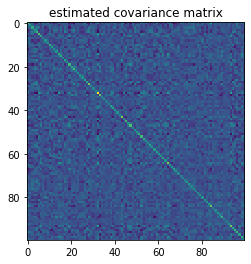

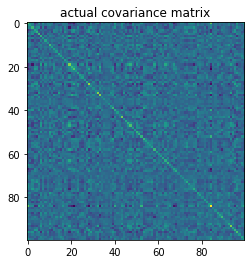

In [26]:
plt.imshow(cov_sim)
plt.title("estimated covariance matrix")
plt.show()

plt.imshow(np.cov(samples.T))
plt.title("actual covariance matrix")
plt.show()

The minimization occurs by assuming a multivariate normal distribution (see van Bergen 2018) with 4 sources (W, rho, sig, tau) of information and trying to match the actual distribution. Multivariate normal distributions can be defined by a covariance matrix. Using a cholesky defactorization of a covariance matrix is a way to make this minimization process more tractable.

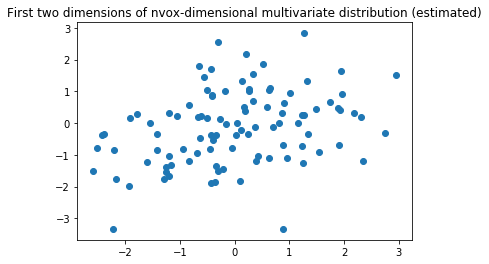

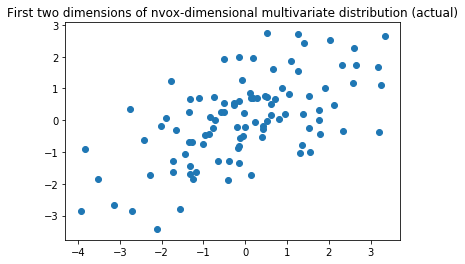

In [34]:
import pymc3 as pm
cov = cov_sim
mu = np.zeros(nvox)
mvn = pm.MvNormal.dist(mu=mu, cov=cov).random(size=100)
plt.scatter(mvn[:,0],mvn[:,1])
plt.title("First two dimensions of nvox-dimensional multivariate distribution (estimated)")
plt.show()

cov = np.cov(samples.T)
mu = np.zeros(nvox)
mvn = pm.MvNormal.dist(mu=mu, cov=cov).random(size=100)
plt.scatter(mvn[:,0],mvn[:,1])
plt.title("First two dimensions of nvox-dimensional multivariate distribution (actual)")
plt.show()

Now that we have estimated values for rho, sig, and tau, we can move from the encoding to the decoding step (see "Visualization of decoding minimization steps" cell above).

For every trial, the estimated stimulus feature is the global minimum of the decoding minimization steps. 

The reconstruction spans feature space instead of channel space, and is obtained by integrating over the normalized likelihood

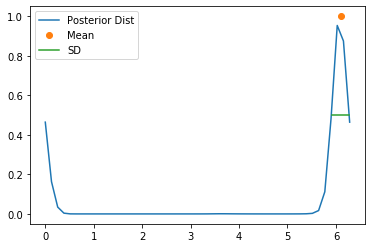

In [27]:
x = np.linspace(0,2*np.pi)
plt.plot(x,fun_lik(x))
plt.plot(np.deg2rad(est[iTrial])*2,1,'o')
plt.plot([np.deg2rad(est[iTrial])*2-np.deg2rad(unc[iTrial])*2,
          np.deg2rad(est[iTrial])*2+np.deg2rad(unc[iTrial])*2,],[.5,.5],'-')
plt.legend(['Posterior Dist','Mean','SD'])

# Pymc3 Implementation?

In [ ]:
corr_mat = 
basis_set =
obs = 

In [ ]:
with pm.Model() as vanbergen_model: 
    
    tau = pm.Normal(3,sigma=.2,shape=nvox)
    cov_mat = pm.cov(tau)
    
    R_tuning = np.corr(f(inits))
    R_arbitrary = shuffle(R_tuning[eye(nvox)])
    corr_mat = R_tuning + R_arbitrary
    
    eps = tt.dot(corr_mat,cov_mat)
    
    e = pm.MvNormal(mu=0,cov=eps)
    
    
    
    
    
    # shared precision parameter per channel, bounded 30-120 deg sd [sd2k(np.deg2rad(120))]
    kappas = pm.Bound(pm.Gamma,lower = .2245,upper = 4.207)('kappas',2.,1.)
    
    # bounded von mises distribution per channel
    mus = [pm.Uniform('mu_%d' % i, 
                   lower = (2*np.pi)/nchannels*i - np.pi-.2618,
                   upper = ((2*np.pi)/nchannels*i + (2*np.pi)/nchannels) - np.pi-.2618)
       for i in range(nchannels)] #-.2618 = 15 degrees
    
    # weights of each mixture component
    p = pm.Dirichlet('p', a=np.array([1.]*(nchannels+1)))
    
    dists = [
        pm.VonMises.dist(mu=mus[0],kappa=kappas),
        pm.VonMises.dist(mu=mus[1],kappa=kappas),
        pm.VonMises.dist(mu=mus[2],kappa=kappas),
        pm.VonMises.dist(mu=mus[3],kappa=kappas),
        pm.Uniform.dist(lower=-np.pi,upper=np.pi),
    ]
    
    # Convenience transform: radians (-pi to pi) to degrees (0 to 359)
    mus_deg = [pm.Deterministic('mu_deg_%d' % i,
                              np.rad2deg(mus[i]+np.pi))
              for i in range(nchannels)]
    
    # Convenience transform: kappa (in radians) to sd (in degrees)
    sds = pm.Deterministic('sd_deg', k2sd_to_deg_op(kappas))

    # Specify the likelihood
    y = pm.MvNormal('y', w=p, comp_dists=dists, observed=actual_cov) #, total_size=obs.shape)
    
#     posterior = pm.sample(5000, tune=15000, chains=3)


# simulation and more functions

demo of make_vonmises function:


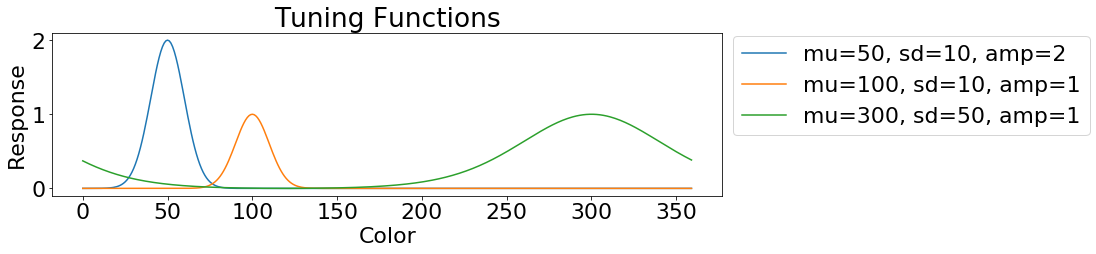

In [46]:
import scipy as sp
import pymc3 as pm
import copy
import collections
import theano
import theano.tensor as tt

# change default plotting
plt.rcParams.update({'font.size': 22, 'figure.figsize': (12,3)})

# Convenience functions
k2sd = lambda k : np.sqrt( -2 * np.log( sp.special.iv(1,k) / sp.special.iv(0,k) ) )

def sd2k(S):
    try:
        len(S)
    except:
        S = np.array([S])
    R = np.exp(-S**2/2)
    K = 1/(R**3 - 4 * R**2 + 3 * R)
    if np.any(R < 0.85):
        K[R < 0.85] = -0.4 + 1.39 * R[R < 0.85] + 0.43/(1 - R[R < 0.85])
    if np.any(R < 0.53):
        K[R < 0.53] = 2 * R[R < 0.53] + R[R < 0.53]**3 + (5 * R[R < 0.53]**5)/6
    if len(S) == 1:
        K = float(K)
    return K

def inverse_transform(x,f_range=360,samps=5000):
    X=[]
    for f in range(f_range):
        X=np.concatenate((X,np.repeat(f,np.ceil(x[f]*samps))))
    return np.random.choice(X,samps,replace=False)

def dim_reduce(x):
    least_freq_feature = collections.Counter(x).most_common()[-1][0]
    least_freq_feature_cnt = len(x[x==least_freq_feature])
    y = [];
    for f in np.unique(x):
        y = np.concatenate((y,np.repeat(f,len(x[x==f])-least_freq_feature_cnt)))
    return y

def half_dim_reduce(x):
    least_freq_feature = collections.Counter(x).most_common()[-1][0]
    least_freq_feature_cnt = len(x[x==least_freq_feature])/2
    y = [];
    for f in np.unique(x):
        y = np.concatenate((y,np.repeat(f,len(x[x==f])-least_freq_feature_cnt)))
    return y

def third_dim_reduce(x):
    least_freq_feature = collections.Counter(x).most_common()[-1][0]
    least_freq_feature_cnt = 2/3 * len(x[x==least_freq_feature])
    y = [];
    for f in np.unique(x):
        y = np.concatenate((y,np.repeat(f,len(x[x==f])-least_freq_feature_cnt)))
    return y

def wrap360(a,b):
    try:
        len(a);len(b);
    except:
        a = np.array([a]); b= np.array([b])
    diff = np.full(len(a),np.nan)
    for k in np.arange(len(a)):
        diff[k] = b[k] - a[k]
        if diff[k] < -180:
            diff[k] = b[k] - a[k] + 360
        elif diff[k] > 180:
            diff[k] = b[k] - a[k] - 360
    return diff

def within360(y):
    x = copy.deepcopy(y)
    try:
        len(x)
    except:
        x = np.array([x])
    x[x>359] = x[x>359]-360
    x[x>359] = x[x>359]-360
    x[x<0] = x[x<0]+360
    return x

import numpy as np

def normalize(x):
    if np.any(np.isnan((x - np.min(x)) / (np.max(x) - np.min(x)))):
        return x
    else:
        return (x - np.min(x)) / (np.max(x) - np.min(x))    
    
def norm0(x):
    return x / np.max(x)

def betw01(x):
    if (x>1):
        x=1
    elif (x<0):
        x=0
    return x

def sumfix(x):
    if (np.min(x)<0):
        x = x - np.min(x)
    return x / np.sum(x)

def within180(x):
    x[x<0] = x[x<0]+360
    x[x>180] = x[x>180]-360
    return np.abs(x)

def within_pi(k):
    while (np.any(k<np.pi) or np.any(k>np.pi)):
        k[k>np.pi] -= np.pi*2
        k[k<-np.pi] += np.pi*2
    return k

def in360_scalar(x):
    while x>359:
        x=x-360
    while x<0:
        x=x+360
    return x

def basis_features(basis_points,trial_features):
    b = np.argmin(np.abs(np.subtract.outer(np.concatenate([basis_points,[basis_points[0]+360]]), trial_features)),axis=0)
    b[b==np.max(b)]=0
    return b

def circmean(samples, high=359, low=0, axis=None, weights=None):
    """
    Compute the circular mean for samples in a range, allowing for input weights
    Edited from scipy.stats.circmean by Paul Scotti to allow for weighting
    """
    samples = np.asarray(samples)

    # Recast samples as radians that range between 0 and 2 pi
    sin_samp = sp.sin((samples - low)*2.*np.pi / (high - low))
    cos_samp = sp.cos((samples - low)*2.*np.pi / (high - low))

    if weights is not None:
        weights = weights / np.sum(weights)
        sin_samp = sin_samp * weights / scl
        cos_samp = cos_samp * weights / scl

    sin_sum = sin_samp.sum(axis=axis)
    cos_sum = cos_samp.sum(axis=axis)

    res = sp.arctan2(sin_sum, cos_sum)

    if res < low and high > np.pi:
        res += np.deg2rad(high+1)

    return np.round(res*(high - low)/2.0/np.pi + low,6)

def make_vonmises(xx,mu,sd,amp=1):
    res = np.exp(sd2k(np.deg2rad(sd))*np.cos(np.deg2rad(xx-mu)))/(2*np.pi*sp.special.i0(sd2k(np.deg2rad(sd))))
    res[np.isnan(res)] = 0 # if requesting a stick function (very small sd), return a stick function
    if np.all(res==0):
        res[int(np.floor(mu))] = amp
    norm_res = (res - np.min(res)) / (np.max(res) - np.min(res)) 
    return norm_res * amp

def make_vonmises_iter(xx,mu,sd,amp):
    res1 = np.full( (360,len(mu)) , np.nan)
    for i in range(len(mu)):
        res = np.exp(sd2k(np.deg2rad(sd[i]))*np.cos(np.deg2rad(xx-mu[i])))/(2*np.pi*sp.special.i0(sd2k(np.deg2rad(sd[i]))))
        res[np.isnan(res)] = 0 
        if np.all(res==0):
            res[int(np.floor(mu[i]))] = amp[i]
        norm_res = (res - np.min(res)) / (np.max(res) - np.min(res)) 
        res1[:,i] = norm_res * amp[i]
    return res1

def make_vonmises_iter2(xx,mu,sd,amp):
    res1 = np.full( (360,len(mu)) , np.nan)
    for i in range(len(mu)):
        res = np.exp(sd2k(np.deg2rad(sd[i]))*np.cos(np.deg2rad(xx-mu[i])))/(2*np.pi*sp.special.i0(sd2k(np.deg2rad(sd[i]))))
        res[np.isnan(res)] = 0 
        if np.all(res==0):
            res[int(np.floor(mu[i]))] = amp[i]
        norm_res = (res - np.min(res)) / (np.max(res) - np.min(res)) 
        res1[:,i] = norm_res * amp[i]
    for x in xx:
        res1[int(x),:] = norm0(res1[int(x),:])
    return res1

def make_vonmises_iter_unif(xx,mu,sd,unif,amp):
    res1 = np.full( (360,len(mu)+1) , np.nan)
    for i in range(len(mu)):
        res = np.exp(sd2k(np.deg2rad(sd[i]))*np.cos(np.deg2rad(xx-mu[i])))/(2*np.pi*sp.special.i0(sd2k(np.deg2rad(sd[i]))))
        res[np.isnan(res)] = 0 
        if np.all(res==0):
            res[int(np.floor(mu[i]))] = amp[i]
        norm_res = (res - np.min(res)) / (np.max(res) - np.min(res)) 
        res1[:,i] = norm_res * amp[i]
    res1[:,-1] = np.ones(360)*unif
#     for x in xx:
#         res1[int(x),:] = normalize0(res1[int(x),:])
    return res1
    
print('demo of make_vonmises function:')
plt.plot(make_vonmises(np.linspace(0,359,360),50,10,[2]),label="mu=50, sd=10, amp=2")
plt.plot(make_vonmises(np.linspace(0,359,360),100,10,[1]),label="mu=100, sd=10, amp=1")
plt.plot(make_vonmises(np.linspace(0,359,360),300,50,[1]),label="mu=300, sd=50, amp=1")
plt.xlabel('Color')
plt.ylabel('Response')
plt.legend(bbox_to_anchor=(1, 1.05))
plt.title("Tuning Functions")
plt.show()

In [47]:
### function to automate voxel simulation ###
def sim_vox(plotting=0):
    # Simulate voxels 
    trial_features = within360(np.random.permutation(np.arange(ntrials)))
#     for t in range(ntrials):
#         if trial_features[t] < 60:
#             trial_features[t] = np.random.randint(300)+60
#     trial_features = np.array([np.arange(360),np.arange(360)]).flatten()
    trial_conds = np.tile(np.array([0,1]),ntrials//2)
    trial_by_vox = np.full((ntrials,nvoxels),np.nan)
    trial_by_id = np.full((ntrials,nvoxels),np.nan)
    trial_by_trial = np.full((ntrials,nvoxels),np.nan)
    for vox in np.arange(nvoxels):
        vox_tuning = make_vonmises( 
            np.linspace(0,359,360),
            vox_mu[vox],
            vox_sd[vox],
            vox_amp[vox])
        for trial in range(ntrials):
            vox_w_noise = vox_tuning[trial_features[trial]] + (np.random.rand()*vox_noise)
            vox_w_noise_and_gain = vox_w_noise * (trial_conds[trial]*vox_gain_diff + 1)
            trial_by_vox[trial,vox] = np.sum(vox_w_noise_and_gain)
            trial_by_trial[trial,vox] = trial
            trial_by_id[trial,vox] = vox
    
    # use trial_by_vox and trial_features to obtain an "observed" distribution for later MCMC/VI
    # I think this is called inverse transform sampling?
    vox_betas = trial_by_vox.flatten()
    vox_id = trial_by_id.flatten()
    vox_trial = trial_by_trial.flatten()
    features = np.repeat(trial_features,nvoxels)
        
    if plotting:
        with plt.rc_context(rc={'font.size': 14, 'figure.figsize': (12,1)}):
            plt.hist(vox_mu,bins=30)
            plt.ylabel('Count')
            plt.title("Each voxel's maximal color preference")
            plt.show()
            plt.hist(vox_amp,bins=30)
            plt.ylabel('Count')
            plt.title("Each voxels's amplitude if maximal stimulus")
            plt.show()
            plt.hist(vox_sd,bins=30)
            plt.ticklabel_format(useOffset=False)
            plt.ylabel('Count')
            plt.title("Each voxel's sd of tuning function")
            plt.show()
    return np.array(trial_features), trial_conds, vox_betas, features, vox_id, vox_trial, trial_by_vox


running sim_vox


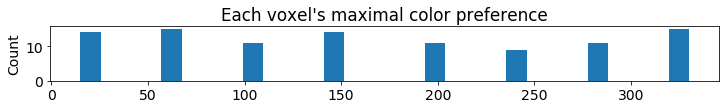

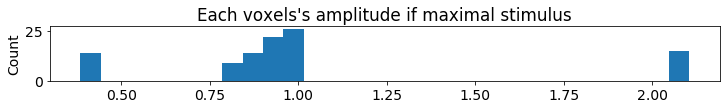

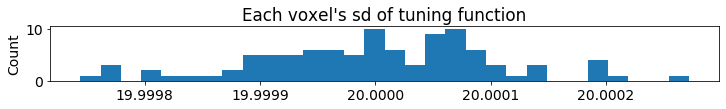

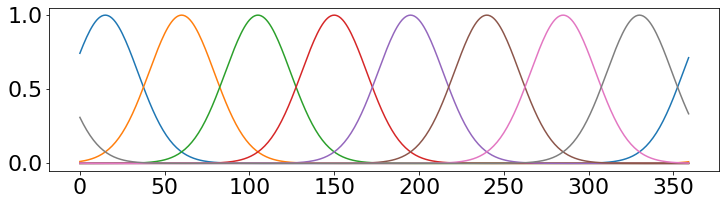

In [48]:
np.random.seed(1)

ntrials = 360
nvoxels = 100
vox_mu_sd = 0
vox_sd_mu = 20
vox_sd_sd = 0.0001
vox_gain_diff = 0 # difference in amplitude between trial conditions
vox_noise = 1 # introduce noise for every voxel
feature_space = np.linspace(0,359,360) # full range of our continuous feature (here 360 degrees in color wheel)

nchannels = 8
vox_nchannels = 8
vox_mu_basis = np.linspace(0,360-(360//vox_nchannels),vox_nchannels)+15 # ground truth voxel receptive fields
basis_points = vox_mu_basis
vox_amp_basis = np.ones(vox_nchannels) # amplitude for given features

# # randomize the amplitudes of the vox basis set
y_amp = pm.Dirichlet.dist(a=np.ones(nchannels)/nchannels)
vox_amp_basis = np.mean(y_amp.random(size=25),axis=0) * nchannels

y_mu = pm.NormalMixture.dist(w=np.ones(vox_nchannels)/vox_nchannels, 
                          mu=vox_mu_basis,
                          sigma=np.ones(vox_nchannels)*vox_mu_sd)
vox_mu = within360(y_mu.random(size=nvoxels))

vox_amp=np.full(nvoxels,np.nan)
for vox in np.arange(nvoxels):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(vox_mu[vox],len(vox_mu_basis)),vox_mu_basis) ) )
    vox_amp[vox] = vox_amp_basis[closest_basis]
    
y_sd = pm.TruncatedNormal.dist(mu=vox_sd_mu, sd=vox_sd_sd, lower=0)
vox_sd = y_sd.random(size=nvoxels)
channel_sd = np.ones(nchannels)*np.mean(vox_sd)
basis_sds=channel_sd

print('running sim_vox')

trial_features, trial_conds, vox_betas, features, vox_id, vox_trial, trial_by_vox = sim_vox(plotting=1)

basis_set = make_vonmises_iter(feature_space, basis_points, channel_sd, np.ones(len(basis_points))) 
actual_weights = basis_set[trial_features,:]

plt.plot(basis_set)